In [67]:
import pandas as pd
import category_encoders as ce
import numpy as np
import time
import math
from matplotlib.pyplot import plot
from feature_engine.imputation import RandomSampleImputer
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn_pandas import DataFrameMapper
from sklearn.utils import estimator_html_repr

# plotly imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# Plotly rendering (work around Plotly rendering issues with GitHub)
pio.renderers.default = "svg"

In [7]:
df = pd.read_csv('data/Airline_customer_satisfaction.csv')

In [8]:
%%html
<style>
table {align:left;display:block}
</style>

|Column name	                  | Description                                                                |
|:------------------------------- |:-------------------------------------------------------------------------- |   
|Satisfaction	                  |Indicates the satisfaction level of the customer.                           |
|Customer Type	                  |Type of customer: 'Loyal Customer' or 'Disloyal Customer’.                  |
|Age	                          |Age of the customer.                                                        |
|Type of Travel	                  |Purpose of the travel: 'Business travel' or 'Personal Travel’.              |
|Class	                          |Class of travel: 'Business', 'Eco', or 'Eco Plus’.                          |
|Flight Distance	              |The distance of the flight in kilometres                                    |
|Seat comfort	                  |Rating of seat comfort provided during the flight (0:Not Applicable;1-5).   |
|Departure/Arrival time convenient|	Rating of the convenience of departure/arrival time (0:Not Applicable;1-5).|
|Food and drink	Rating            |of food and drink quality provided during the flight (0:Not Applicable;1-5).|
|Gate location	Rating            |of gate location convenience (0:Not Applicable;1-5).                        |
|Inflight wifi service            |Rating of inflight wifi service satisfaction (0:Not Applicable;1-5).        |
|Inflight entertainment           |Rating of inflight entertainment satisfaction (0:Not Applicable;1-5).       |
|Online support	                  |Rating of online customer support satisfaction (0:Not Applicable;1-5).      |
|Ease of Online booking	          |Rating of ease of online booking satisfaction ((0:Not Applicable;1-5).      |
|On-board service	              |Rating of on-board service satisfaction (0:Not Applicable;1-5).             |
|Leg room service	              |Rating of leg room service satisfaction (0:Not Applicable;1-5).             |
|Baggage handling	              |Rating of baggage handling satisfaction (0:Not Applicable;1-5).             |
|Checkin service	              |Rating of check-in service satisfaction (0:Not Applicable;1-5).             |
|Cleanliness	                  |Rating of cleanliness satisfaction (0:Not Applicable;1-5).                  |
|Online boarding	              |Rating of online boarding satisfaction (0:Not Applicable;1-5).              |
|Departure Delay in Minutes       |Total departure delay in minutes.                                           |
|Arrival Delay in Minutes	      |Total arrival delay in minutes.                                             |

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

In [10]:
df.head()

satisfaction   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  Gate location  ...  Online support  Ease of Online booking  \
0               0              2  ...               2                       3   
1               0              3  ...               2                       3   
2               0              3  ...               2                       2   
3               0              3  ...               3                       1   
4               0              3  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

### Data Cleanup

#### Cleaning Nulls

In [11]:
df.isnull().sum()

satisfaction                           0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

In [12]:
# cleaning minor number of records (393) where `Arrival Delay in Minutes` is null
print('Number of records before cleaning nulls:', len(df))
df_no_nulls = df.dropna()
len(df_no_nulls)
print('Number of records after cleaning nulls', len(df_no_nulls), '\ncleaned:', len(df) - len(df_no_nulls), 'records')
df = df.dropna()

Number of records before cleaning nulls: 129880
Number of records after cleaning nulls 129487 
cleaned: 393 records


In [13]:
df.isnull().sum()

satisfaction                         0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
dtype: int64

## Understanding the Features

#### Target feature distribution

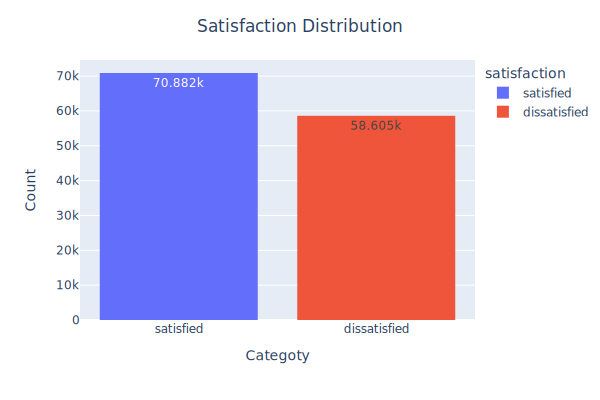

In [14]:
fig = px.histogram(df, x='satisfaction', color='satisfaction', text_auto=True)
fig.update_layout(title='Satisfaction Distribution',
                  title_x=0.5, title_y=0.95,
                  width=600, height=400,
                  yaxis_title='Count',
                  xaxis_title='Categoty')
fig.show()

We can see that the target feature `satisfaction` is quite balanced, so there is no need to work on that.

#### Numerical Features

In [15]:
# Get list of numerical columns
numerical_columns = df.select_dtypes(include='number').columns.tolist()

/tmp/ipykernel_2048750/1092372708.py:6: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Flight Distance'}>,
        <Axes: title={'center': 'Seat comfort'}>,
        <Axes: title={'center': 'Departure/Arrival time convenient'}>],
       [<Axes: title={'center': 'Food and drink'}>,
        <Axes: title={'center': 'Gate location'}>,
        <Axes: title={'center': 'Inflight wifi service'}>,
        <Axes: title={'center': 'Inflight entertainment'}>],
       [<Axes: title={'center': 'Online support'}>,
        <Axes: title={'center': 'Ease of Online booking'}>,
        <Axes: title={'center': 'On-board service'}>,
        <Axes: title={'center': 'Leg room service'}>],
       [<Axes: title={'center': 'Baggage handling'}>,
        <Axes: title={'center': 'Checkin service'}>,
        <Axes: title={'center': 'Cleanliness'}>,
        <Axes: title={'center': 'Online boarding'}>],
       [<Axes: title={'center': 'Departure Delay in Minutes'}>,
        <Axes: title={'center': 'Arrival Delay in Minutes'}>, <Axe

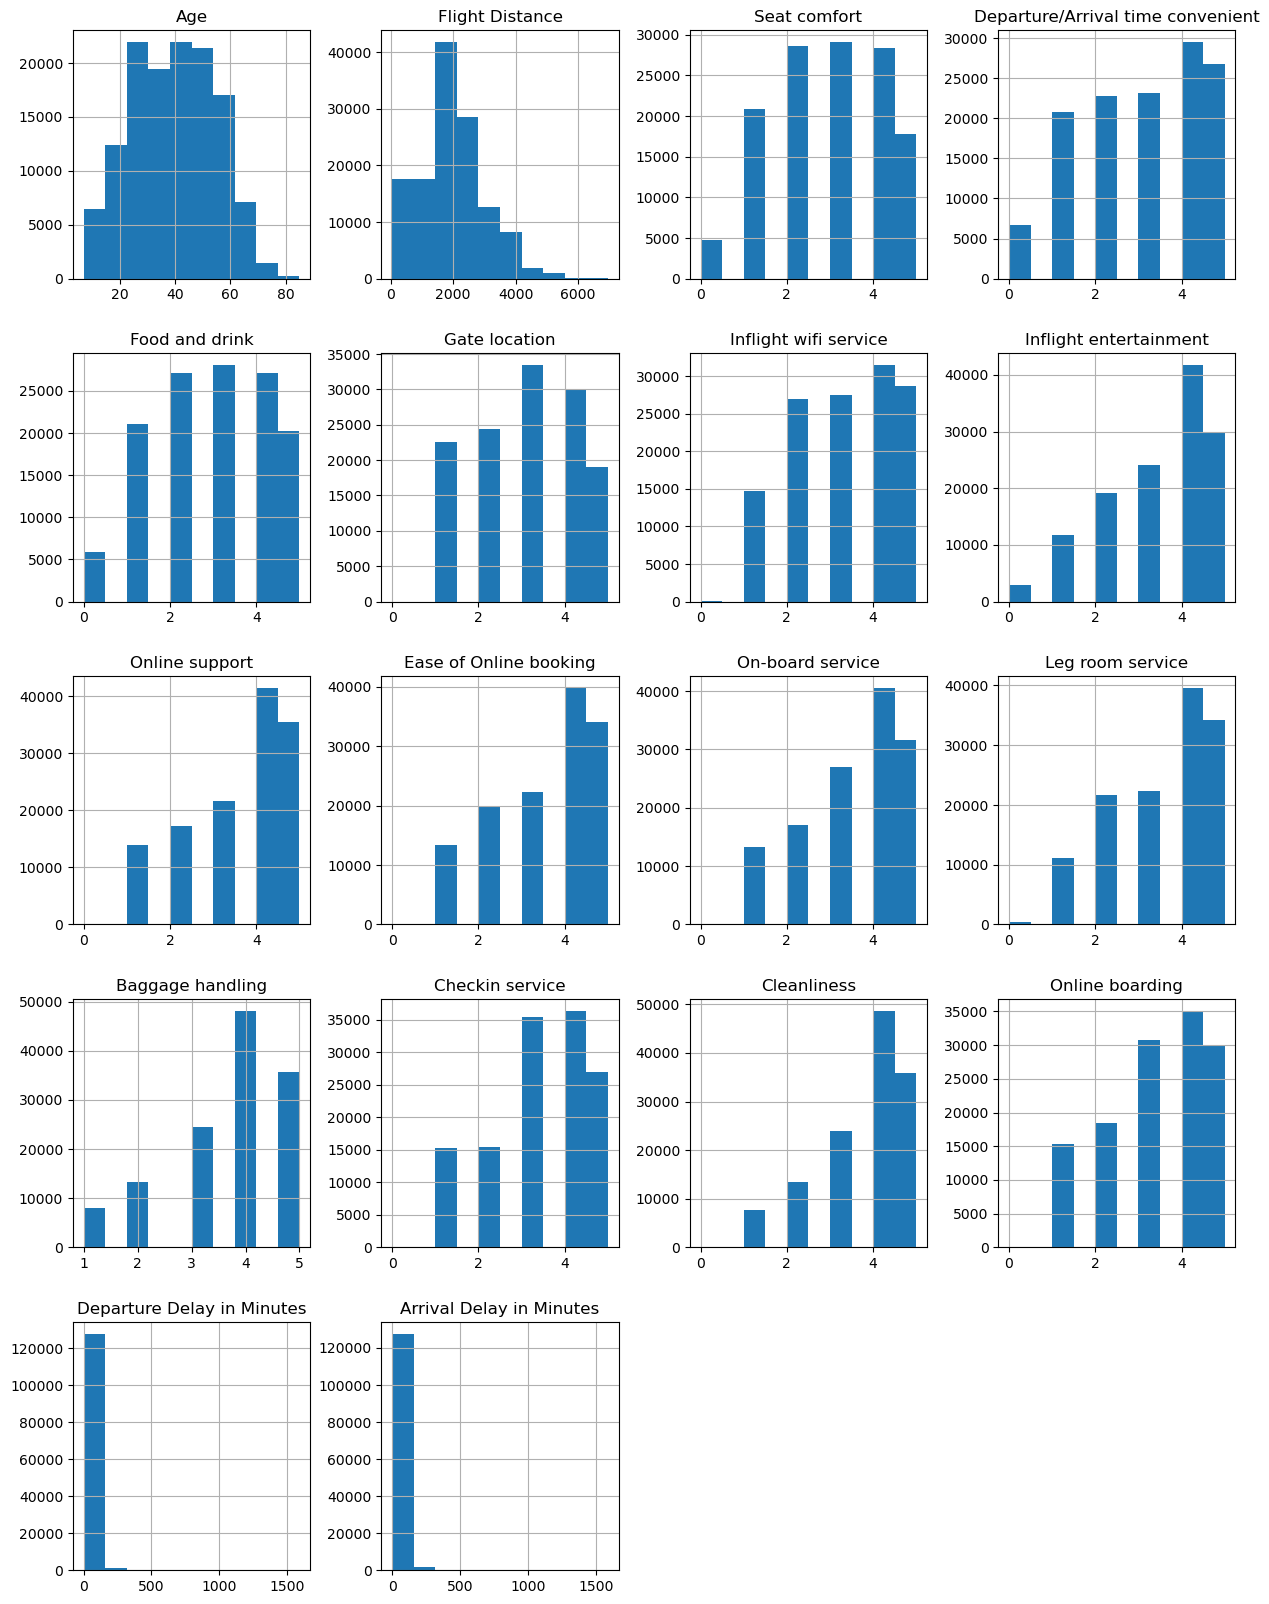

In [16]:
import matplotlib.gridspec as gs

outer_layout = gs.GridSpec(4, 5)
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df[numerical_columns].hist(ax = ax)

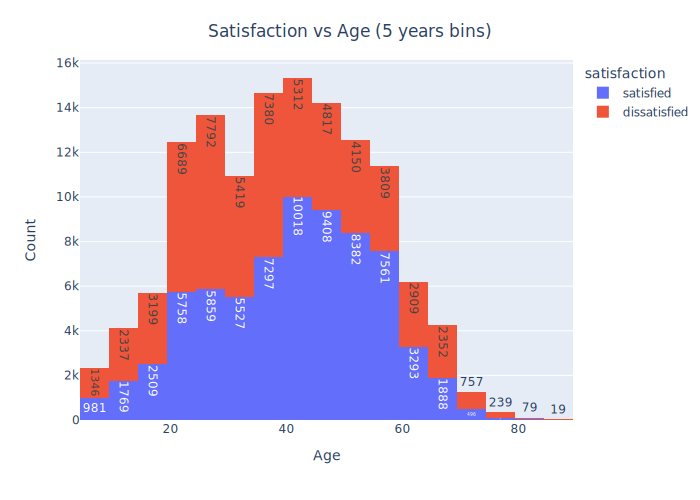

In [17]:
fig = px.histogram(df, x='Age', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Age (5 years bins)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Age')
fig.show()

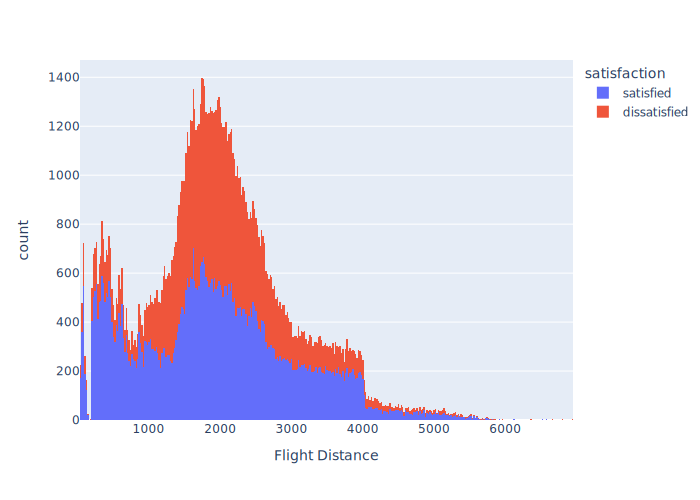

In [18]:
px.histogram(df, x='Flight Distance', color='satisfaction')

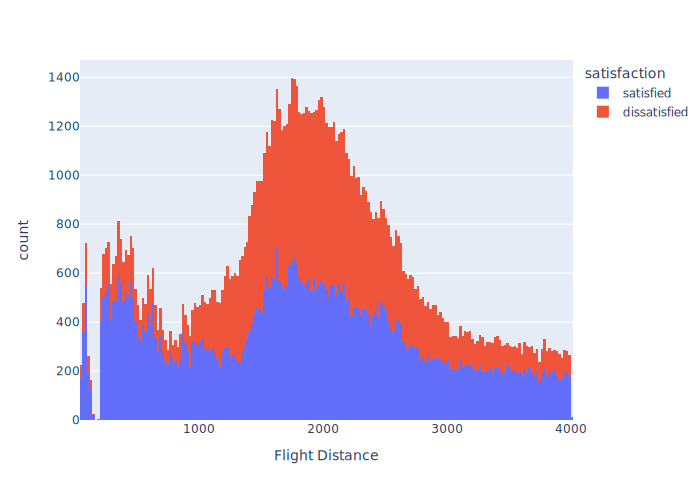

In [19]:
px.histogram(df[df['Flight Distance']<=4000], x='Flight Distance', color='satisfaction')

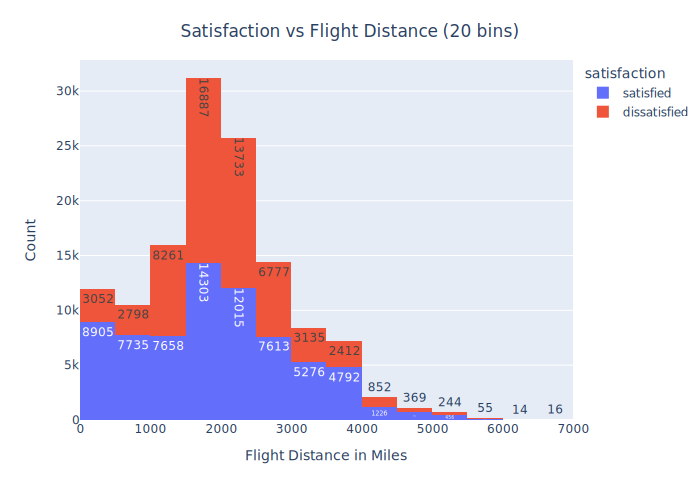

In [20]:
fig = px.histogram(df[(df['Flight Distance']<=10000)], x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance (20 bins)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

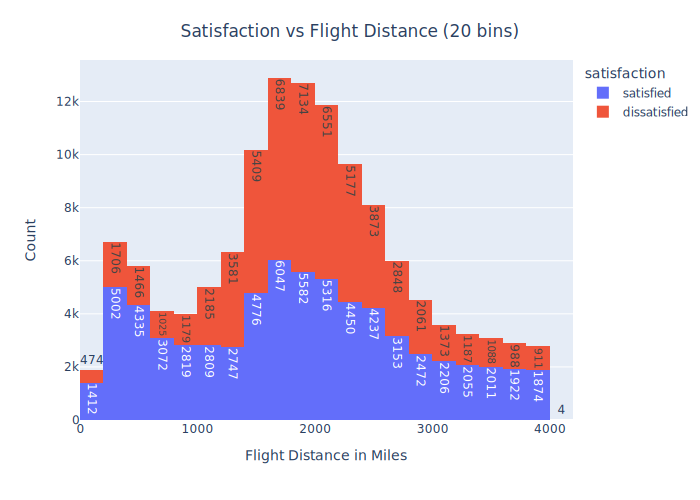

In [21]:
fig = px.histogram(df[(df['Flight Distance']<=4000)], x='Flight Distance', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Flight Distance (20 bins)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Flight Distance in Miles')
fig.show()

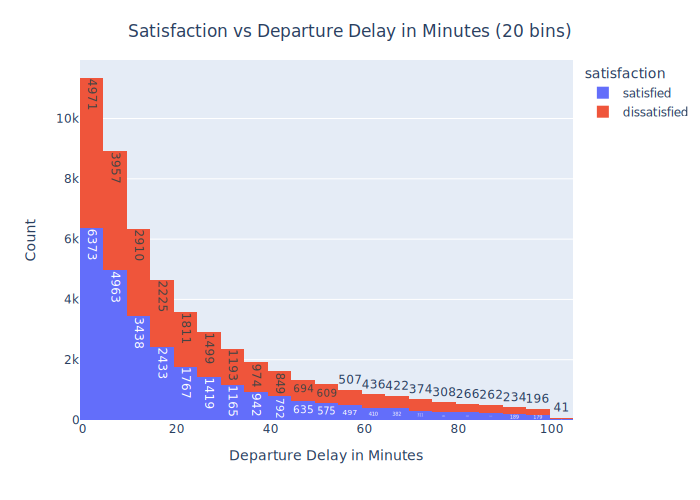

In [22]:
fig = px.histogram(df[(df['Departure Delay in Minutes']<=100) & (df['Departure Delay in Minutes']>0)], x='Departure Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Departure Delay in Minutes (20 bins)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Departure Delay in Minutes')
fig.show()

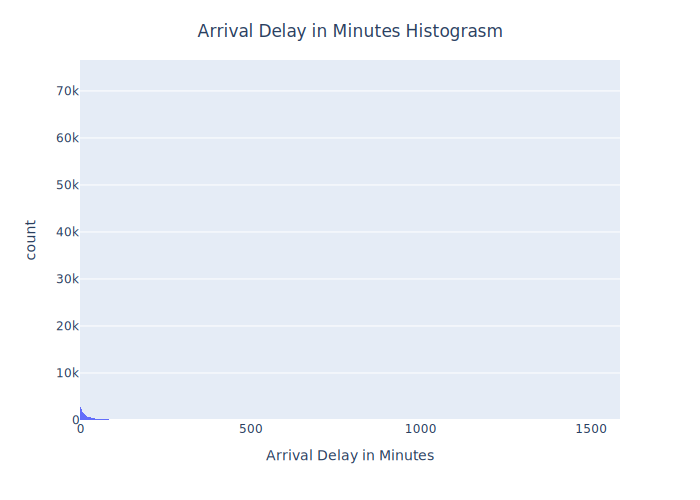

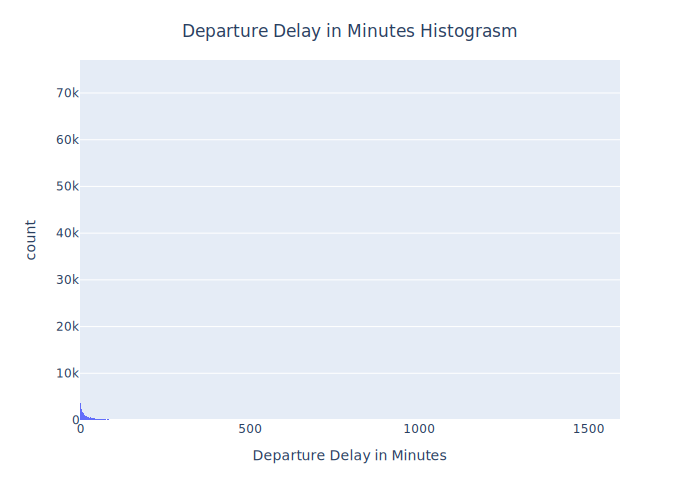

In [23]:
px.histogram(df, x='Arrival Delay in Minutes').update_layout(title='Arrival Delay in Minutes Histograsm',
                                                             title_x=0.5, title_y=0.95).show()
px.histogram(df, x='Departure Delay in Minutes').update_layout(title='Departure Delay in Minutes Histograsm',
                                                             title_x=0.5, title_y=0.95).show()

Seems like we have some outliers at `Arrival Delay in Minutes` and `Departure Delay in Minutes` - lets remove them

In [24]:
px.box(df, x='Arrival Delay in Minutes').update_layout(title='Box Plot for Arrival Delay in Minutes',
                  title_x=0.5, title_y=0.95).show()
px.box(df, x='Departure Delay in Minutes').update_layout(title='Box Plot for Departure Delay in Minutes',
                  title_x=0.5, title_y=0.95).show()


In [25]:
from scipy.stats import zscore
features_with_outliers = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']
outliers_list = []

for f in features_with_outliers:
    z_score = zscore(df[f])
    
    # removing outlier that are more than 3 standard deviations away from the mean
    threshold = 3
    
    outliers = df[abs(z_score) > threshold]
    outliers_list.extend(outliers.index)
    print(f'Number of outliers found for feature {f}: {len(outliers)}')

# dropping outliers 
df_len_before = len(df)
print(f'df size before removing outliers: {df_len_before}')
df = df.drop(index=outliers_list).reset_index(drop=True)
print(f'df size after removing outliers: {len(df)}.\nTotal number of records removed: {df_len_before - len(df)} ')

Number of outliers found for feature Departure Delay in Minutes: 2716
Number of outliers found for feature Arrival Delay in Minutes: 2742
df size before removing outliers: 129487
df size after removing outliers: 126446.
Total number of records removed: 3041 


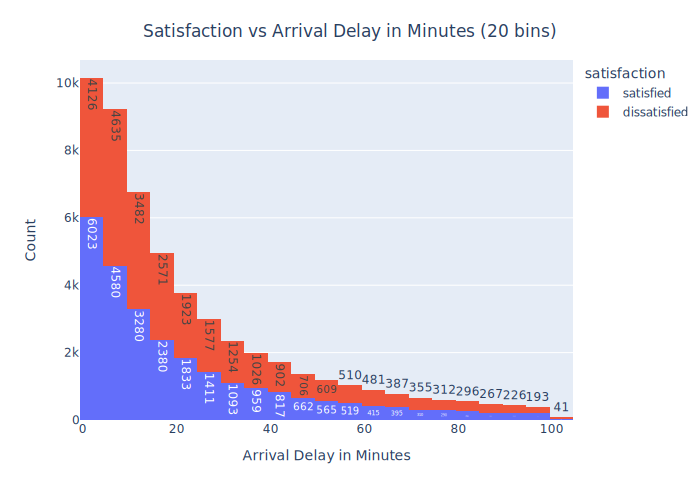

In [26]:
fig = px.histogram(df[(df['Arrival Delay in Minutes']<=100) & (df['Arrival Delay in Minutes']>0)], x='Arrival Delay in Minutes', color='satisfaction', nbins=20, text_auto='.0f')
fig.update_layout(title='Satisfaction vs Arrival Delay in Minutes (20 bins)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Arrival Delay in Minutes')
fig.show()

#### Categorical features and Customer Survey features

We will now analyze the following features: 
 ['Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


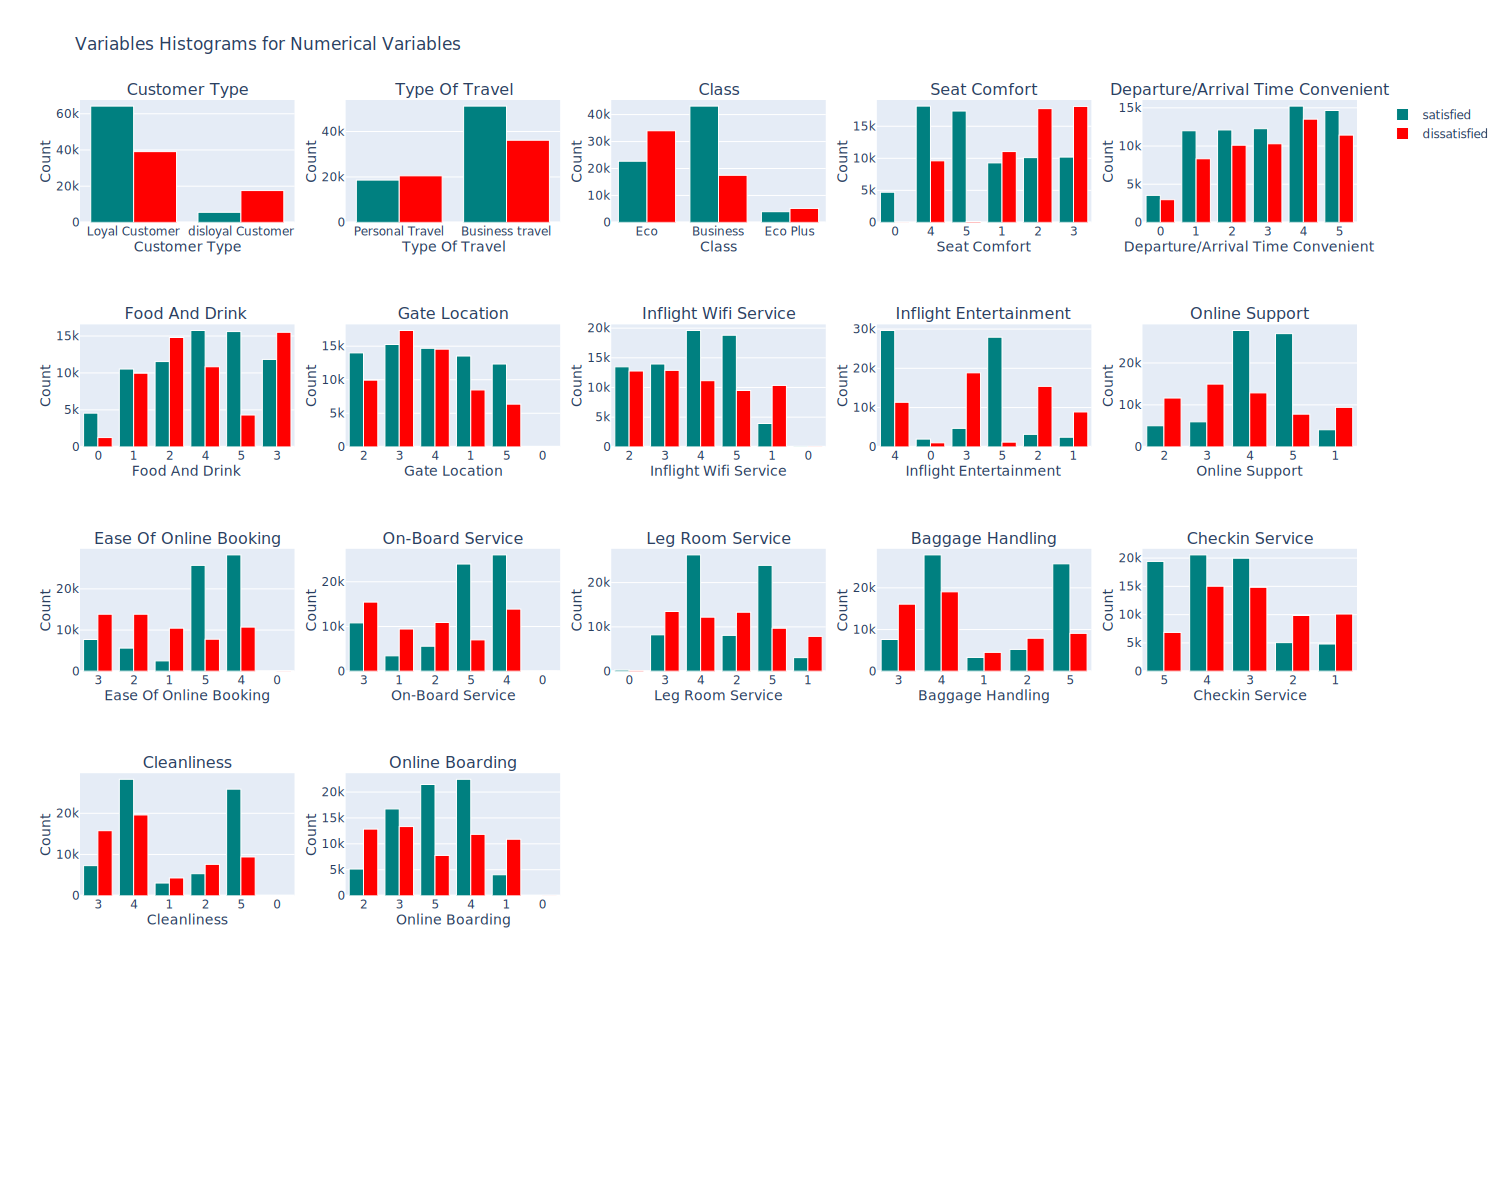

In [27]:
import math
from plotly.subplots import make_subplots

columns = df.columns.tolist()
# removing numerical features that are not customer survey features
for x in ['Age','Flight Distance','Arrival Delay in Minutes', 'Departure Delay in Minutes', 'satisfaction']:
    columns.remove(x)
    
print(f'We will now analyze the following features: \n {columns}')
dimension = math.ceil(np.sqrt(len(columns)))
fig = make_subplots(cols = dimension, rows = dimension, subplot_titles=(list(map(lambda x: x.replace('_', " ").title(), columns))))

df_satisfied = df[df['satisfaction'] == 'satisfied']
df_dissatisfied = df[df['satisfaction'] == 'dissatisfied']

for i, column in enumerate(columns):
    row = math.floor((i + dimension) / dimension) 
    col = ((i + dimension) % dimension) + 1
    fig.add_histogram(x = df_satisfied[column], row = row, col = col, name='satisfied', marker_color='teal', showlegend=(i==0))
    fig.add_histogram(x = df_dissatisfied[column], row = row, col = col, name='dissatisfied', marker_color='red', showlegend=(i==0))
    fig['layout'][f'yaxis{i+1}']['title'] = 'Count'
    fig['layout'][f'xaxis{i+1}']['title'] = column.replace('_', " ").title()
    fig['layout'][f'yaxis{i+1}']['title']['standoff'] = 0
    fig['layout'][f'xaxis{i+1}']['title']['standoff'] = 0
    fig.update_traces(marker_line_width=1,marker_line_color="white")
    
    
fig.update_layout(height=1200, width=1500, title_text="Variables Histograms for Numerical Variables")
fig.update_xaxes(type='category')
fig.show()

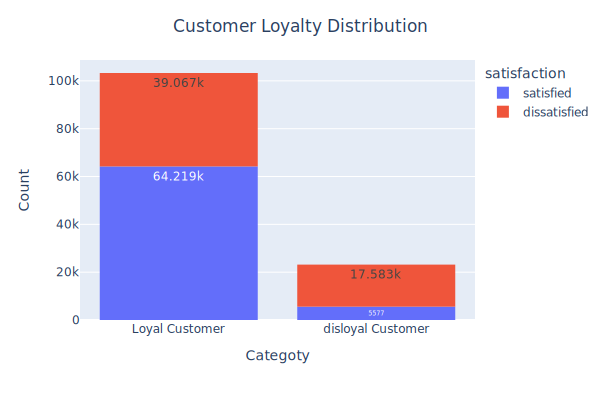

In [28]:
fig = px.histogram(df, x='Customer Type', color='satisfaction', text_auto=True)
fig.update_layout(title='Customer Loyalty Distribution',
                  title_x=0.5, title_y=0.95,
                  width=600, height=400,
                  yaxis_title='Count',
                  xaxis_title='Categoty')
fig.show()

In [29]:
satisfied = df[df.satisfaction.isin(['satisfied'])]
dissatisfied = df[df.satisfaction.isin(['dissatisfied'])]
len(dissatisfied)

56650

In [30]:
# helper function to generate ratio satisfaction DataFrame
def get_satisfaction_rate_dataframe(mydf, category):
    df_all = mydf.groupby(category).agg('count')['satisfaction']
    df_category_satisfied = df[df.satisfaction.isin(['satisfied'])].groupby(category).agg('count')['satisfaction']
    df_category_dissatisfied = df[df.satisfaction.isin(['dissatisfied'])].groupby(category).agg('count')['satisfaction']
    category_satisfied_ratio = df_category_satisfied / df_all
    category_dissatisfied_ratio = 1 - category_satisfied_ratio
    categoty_satisfaction_frame = {'satisfied': category_satisfied_ratio,
         'dissatisfied': category_dissatisfied_ratio}
    cat_frame = pd.DataFrame(categoty_satisfaction_frame)
    return cat_frame

# calculates the satisfaction rate given a dataframe
def get_satisfaction_rate(df):
    return len(df[df.satisfaction.isin(['satisfied'])]) / len(df)

In [31]:
base_satisfaction = round(get_satisfaction_rate(df), 3)
print(f'base satisfaction rate is: {base_satisfaction}')

base satisfaction rate is: 0.552


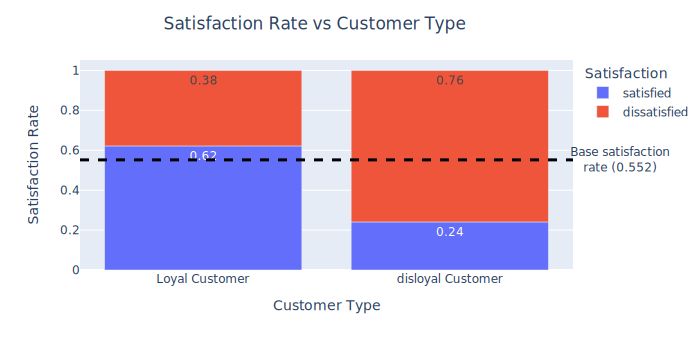

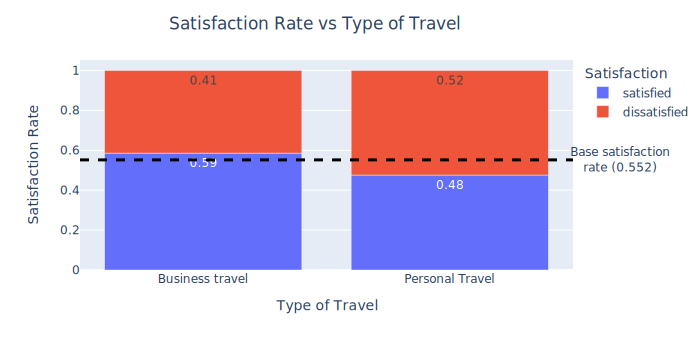

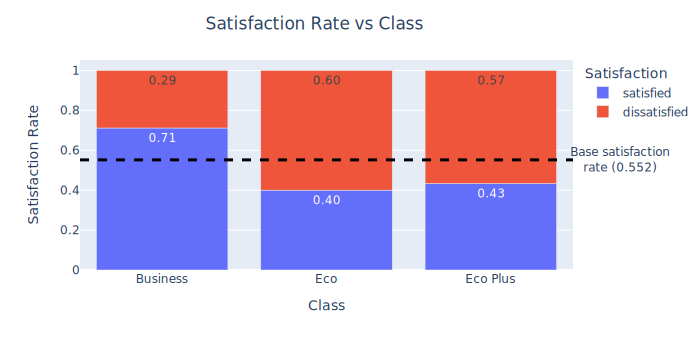

In [32]:
columns = ['Customer Type', 'Type of Travel', 'Class']
for column in columns:
  df_satisfied= get_satisfaction_rate_dataframe(df, column)

  fig = px.bar(df_satisfied, x=df_satisfied.index, text_auto='.2f', y=['satisfied',  'dissatisfied'], labels={'variable': 'Satisfaction'}).update_xaxes(type='category')
  fig.add_hline(y=base_satisfaction, line_width=3, line_dash="dash", line_color="black",  annotation_text=f"Base satisfaction<br>rate ({base_satisfaction})",
                              annotation_position="right")
  fig.update_layout(title=f'Satisfaction Rate vs {column}', title_x = 0.45, title_y = 0.95,
                width=700, height=350,
                yaxis_title = 'Satisfaction Rate',
                    
                xaxis={'categoryorder':'sum ascending'},
                xaxis_title = column)
  fig.show()

## Features Engineering

In [33]:
# label_encoder = LabelEncoder()
# df['Customer Type'] = label_encoder.fit_transform(df['Customer Type'])
df.head()

satisfaction   Customer Type  Age   Type of Travel Class  Flight Distance  \
0    satisfied  Loyal Customer   65  Personal Travel   Eco              265   
1    satisfied  Loyal Customer   15  Personal Travel   Eco             2138   
2    satisfied  Loyal Customer   60  Personal Travel   Eco              623   
3    satisfied  Loyal Customer   70  Personal Travel   Eco              354   
4    satisfied  Loyal Customer   30  Personal Travel   Eco             1894   

   Seat comfort  Departure/Arrival time convenient  Food and drink  \
0             0                                  0               0   
1             0                                  0               0   
2             0                                  0               0   
3             0                                  0               0   
4             0                                  0               0   

   Gate location  ...  Online support  Ease of Online booking  \
0              2  ...               2                       3   
1              3  ...               2                       2   
2              3  ...               3                       1   
3              3  ...               4                       2   
4              3  ...               2                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 3                 3                 4                4   
2                 1                 0                 1                4   
3                 2                 0                 2                4   
4                 5                 4                 5                5   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            4                2                           0   
2            1                3                           0   
3            2                5                           0   
4            4                2                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

In [34]:
# encoding categorical target column to numeric
df['satisfaction_numeric'] = df['satisfaction'].map({'satisfied': 0, 'dissatisfied': 1})

# encoding categorical columns to numerical
df['Class'] = df['Class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 2})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer': 0, 'disloyal Customer': 1})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})

df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].astype(int)

df.head()

satisfaction  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0    satisfied              0   65               0      0              265   
1    satisfied              0   15               0      0             2138   
2    satisfied              0   60               0      0              623   
3    satisfied              0   70               0      0              354   
4    satisfied              0   30               0      0             1894   

   Seat comfort  Departure/Arrival time convenient  Food and drink  \
0             0                                  0               0   
1             0                                  0               0   
2             0                                  0               0   
3             0                                  0               0   
4             0                                  0               0   

   Gate location  ...  Ease of Online booking  On-board service  \
0              2  ...                       3                 3   
1              3  ...                       2                 3   
2              3  ...                       1                 1   
3              3  ...                       2                 2   
4              3  ...                       2                 5   

   Leg room service  Baggage handling  Checkin service  Cleanliness  \
0                 0                 3                5            3   
1                 3                 4                4            4   
2                 0                 1                4            1   
3                 0                 2                4            2   
4                 4                 5                5            4   

   Online boarding  Departure Delay in Minutes  Arrival Delay in Minutes  \
0                2                           0                         0   
1                2                           0                         0   
2                3                           0                         0   
3                5                           0                         0   
4                2                           0                         0   

   satisfaction_numeric  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 23 columns]

In [35]:
df['On-board service'].value_counts()
# df['On-board service'] = df['On-board service'].replace(0, pd.NA)

On-board service
4    39886
5    30957
3    26254
2    16481
1    12863
0        5
Name: count, dtype: int64

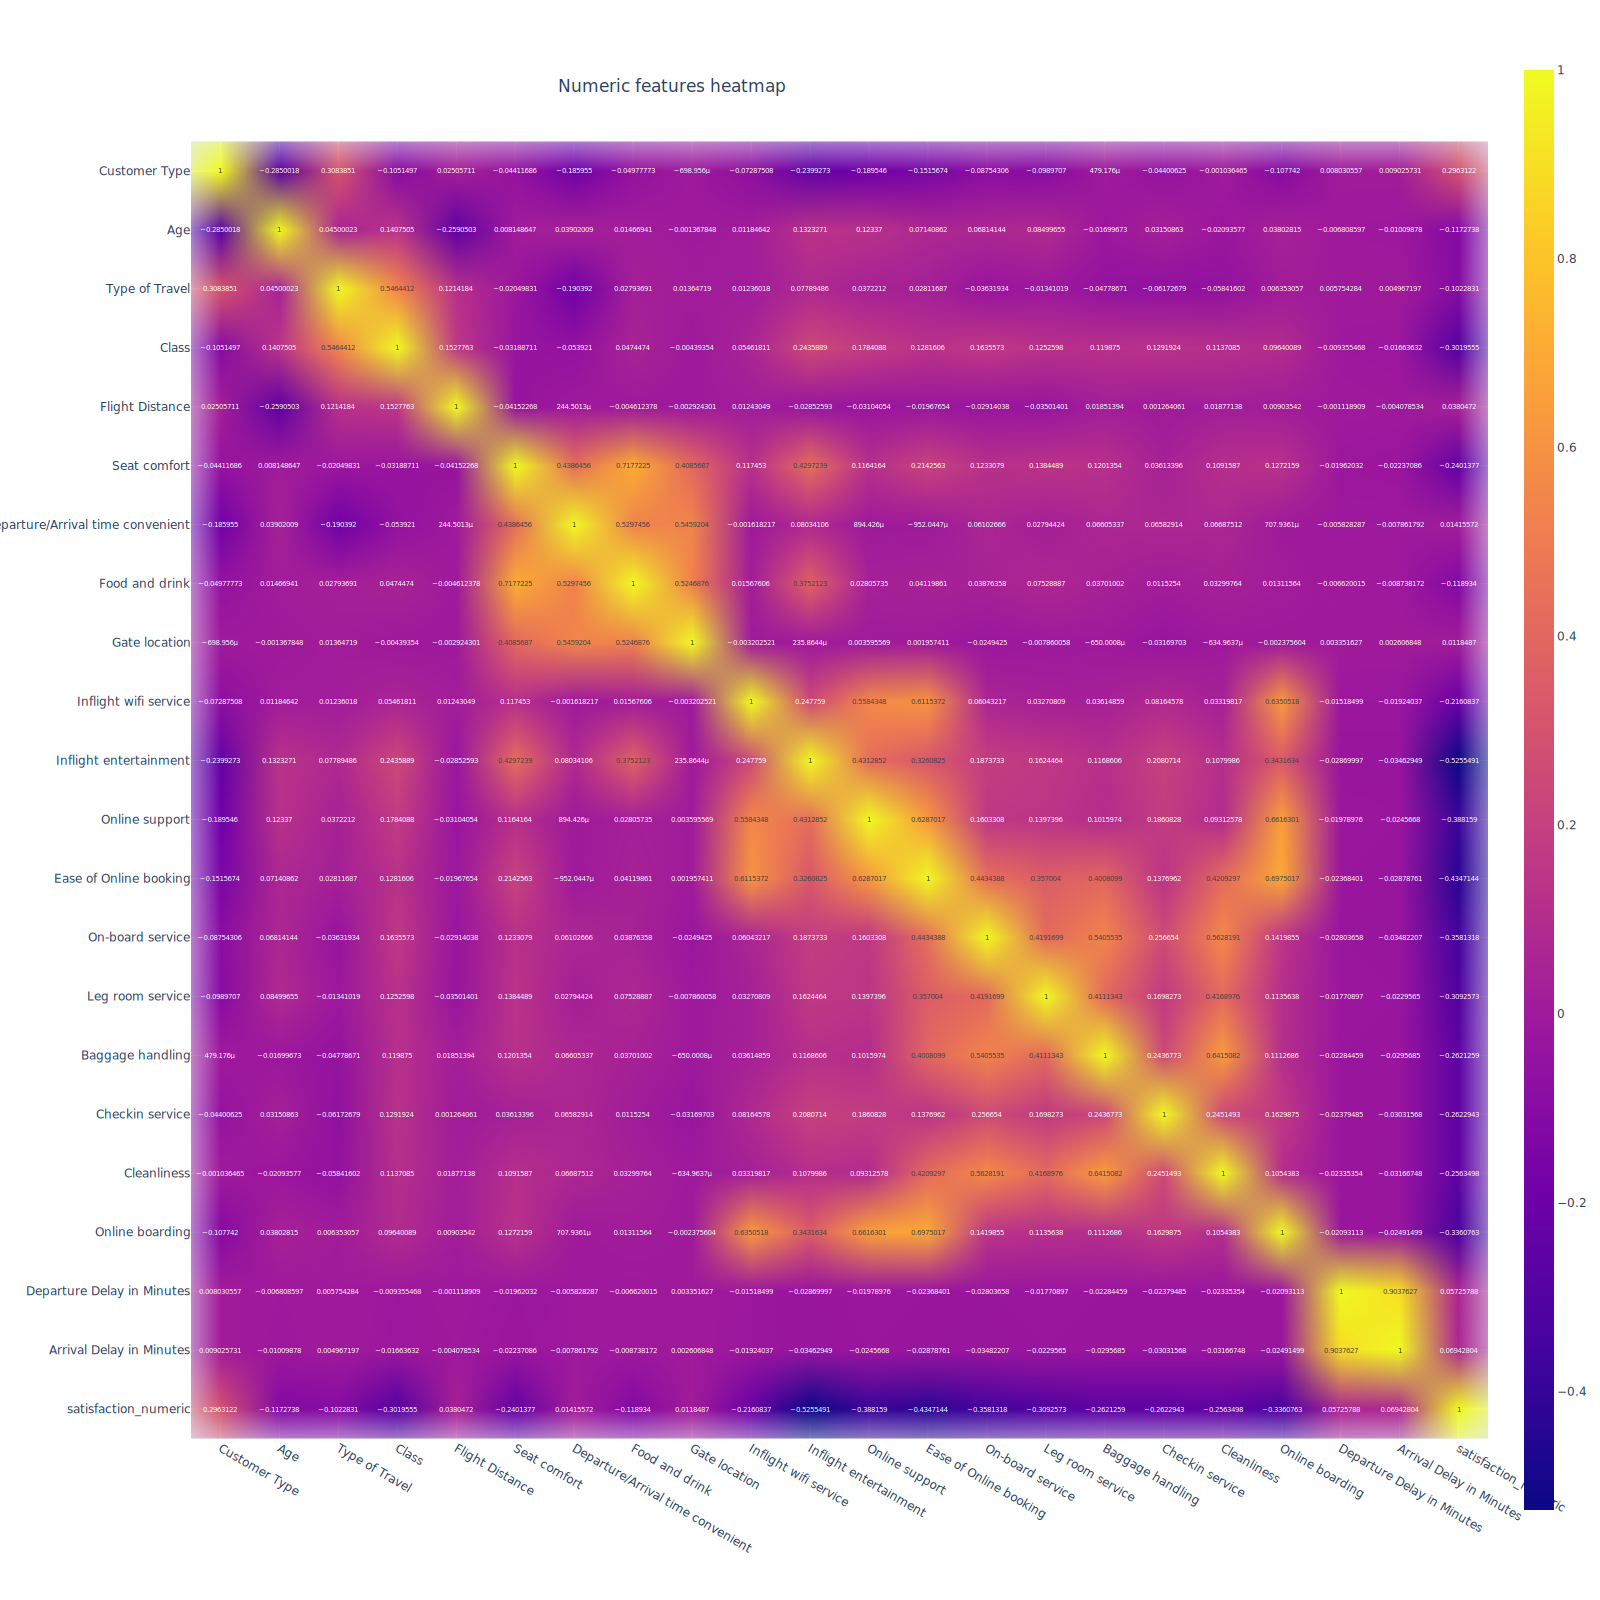

In [36]:
# building a heatmap for numeric features
df_numeric = df.select_dtypes(include=np.number)
fig = px.imshow(df_numeric.corr(), text_auto=True)
fig.update_layout(title='Numeric features heatmap',
                  title_x=0.42, title_y=0.95,
                  width=1600, height=1600).show()

We can see high correlatin of the target feature `statisfaction_numeric` to `Inflight entertainment`(-0.53), `Online support`(-0.39), `Ease of onboarding`(-0.43), `On-board service`(-0.36) and  `Online boarding`(-0.34).

## Split Data Train/Test

In [61]:
from sklearn.model_selection import train_test_split

df_numeric = df.drop(['satisfaction', 'satisfaction_numeric'], axis=1)
X = df_numeric
x_train, x_test, y_train, y_test = train_test_split(df_numeric, df['satisfaction_numeric'], test_size=0.25)

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126446 entries, 0 to 126445
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   Customer Type                      126446 non-null  int64
 1   Age                                126446 non-null  int64
 2   Type of Travel                     126446 non-null  int64
 3   Class                              126446 non-null  int64
 4   Flight Distance                    126446 non-null  int64
 5   Seat comfort                       126446 non-null  int64
 6   Departure/Arrival time convenient  126446 non-null  int64
 7   Food and drink                     126446 non-null  int64
 8   Gate location                      126446 non-null  int64
 9   Inflight wifi service              126446 non-null  int64
 10  Inflight entertainment             126446 non-null  int64
 11  Online support                     126446 non-null  int64
 12  Ea

## A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [63]:
import pandas as pd
import time

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [56]:
# Create anf fit dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

# Predict the labels for the train and test data
y_pred_train = dummy_clf.predict(x_train)
y_pred_test = dummy_clf.predict(x_test)

# Calculate the accuracy score for the train data
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy score for the train data:", accuracy_train)

# Calculate the accuracy score for the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy score for the test data:", accuracy_test)

Accuracy score for the train data: 0.5522381116311094
Accuracy score for the test data: 0.5505351399799652


## Modeling

### Logistic Regression Simple

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier

logisticReg = LogisticRegression(max_iter=5000)
logisticReg.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [58]:
y_pred_train_lr = logisticReg.predict(x_train)
y_pred_test_lr = logisticReg.predict(x_test)

print(f'Logistic regression train score: {accuracy_score(y_train, y_pred_train_lr)}')
print(f'Logistic regression test score: {accuracy_score(y_test, y_pred_test_lr)}')

Logistic regression train score: 0.8295760101973408
Logistic regression test score: 0.8266462803817156


###  Comparing different classification models  

Analyzing model:  Logistic Regression
Confusion Matrix for Gradient Boost: 

              precision    recall  f1-score   support

           0       0.84      0.85      0.84     17453
           1       0.81      0.81      0.81     14159

    accuracy                           0.83     31612
   macro avg       0.83      0.83      0.83     31612
weighted avg       0.83      0.83      0.83     31612

Analyzing model:  SVM
Confusion Matrix for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.67      0.56      0.61     17453
           1       0.55      0.66      0.60     14159

    accuracy                           0.61     31612
   macro avg       0.61      0.61      0.61     31612
weighted avg       0.62      0.61      0.61     31612

Analyzing model:  KNN
Confusion Matrix for SVM: 

              precision    recall  f1-score   support

           0       0.73      0.75      0.74     17453
           1       0.68      0.65      0.67 

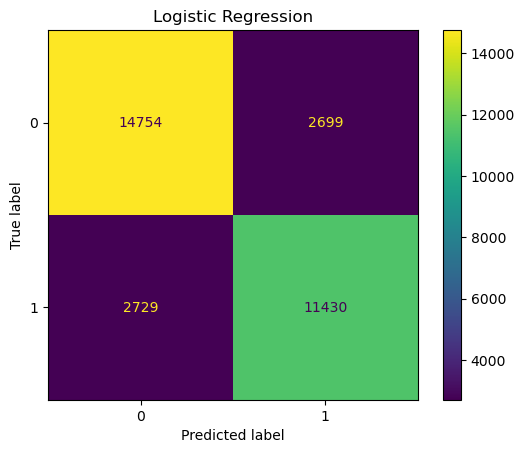

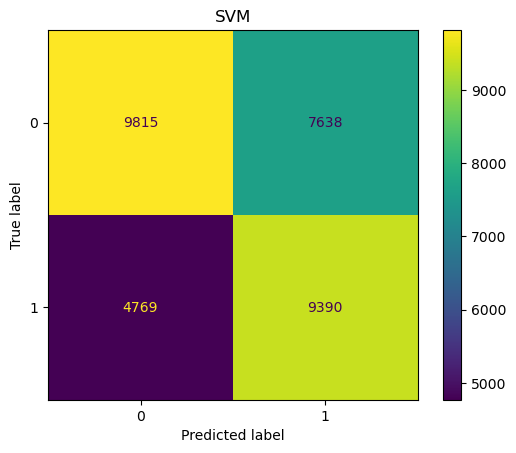

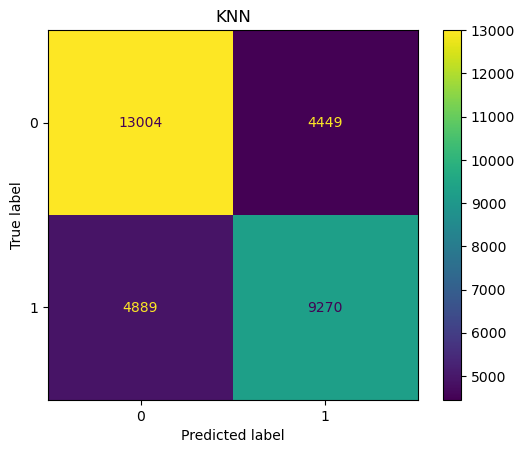

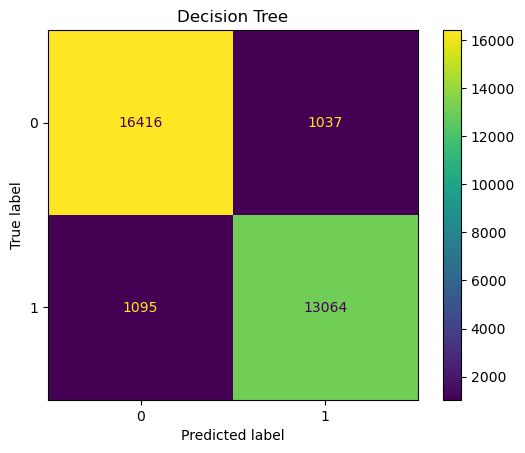

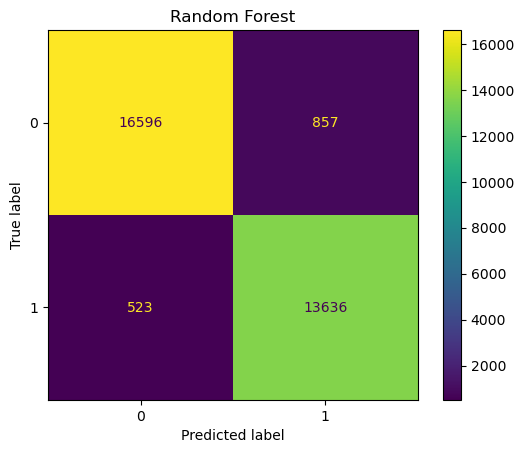

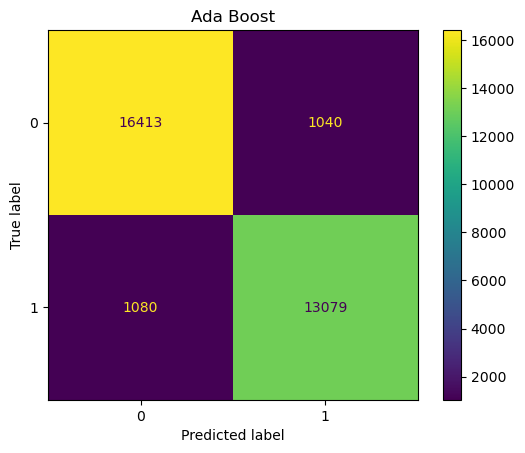

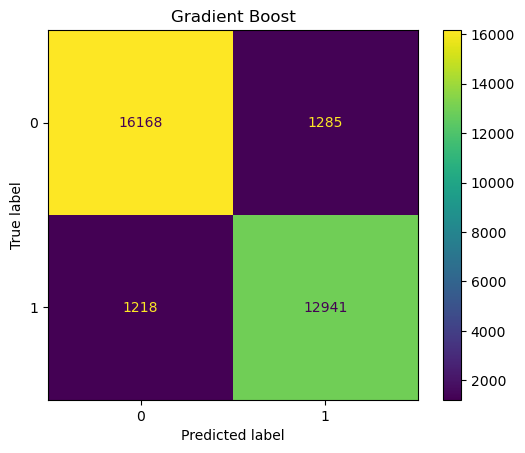

In [79]:
# Create a dictionary to store the results
results = {}

# Models to test
models = [
    {
        'model': LogisticRegression(max_iter=5000),
        'key': 'Logistic Regression'
    },
    {
        'model': SVC(),
        'key': 'SVM'
    },
    {
        'model': KNeighborsClassifier(),
        'key': 'KNN'
    },
    {
        'model': DecisionTreeClassifier(),
        'key': 'Decision Tree'
    },
    {
        'model': RandomForestClassifier(),
        'key': 'Random Forest'
    },
    {
        'model': AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'),
        'key': 'Ada Boost'
    },  
    {
        'model': GradientBoostingClassifier(),
        'key': 'Gradient Boost'
    },  
]

# fit model and calc accuracy and f1
for model in models:
    print('Analyzing model: ', model['key'])
    mdl = model['model']
    start_t = time.time()
    mdl.fit(x_train.values, y_train)
    end_t = time.time()
    y_pred_train = mdl.predict(x_train.values)
    y_pred_test = mdl.predict(x_test.values)
    print(f'Confusion Matrix for {key}: \n')
    cm = confusion_matrix(y_test, y_pred_test, labels=mdl.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mdl.classes_)
    disp.plot()
    disp.ax_.set_title(model['key'])

    key = model['key']
    results[key] = {
        'score': mdl.score(x_test.values, y_test),
        'train_time': end_t - start_t,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_f1': f1_score(y_train, y_pred_train, average='weighted', labels=np.unique(y_pred_train)),
        'test_f1': f1_score(y_test, y_pred_test, average='weighted', labels=np.unique(y_pred_test))
    }
    print(classification_report(y_test, y_pred_test, labels=np.unique(y_pred_test)))


                        score  train_time  train_accuracy  test_accuracy  \
Model                                                                      
Logistic Regression  0.826646    4.348705        0.829576       0.826646   
SVM                  0.611483  183.681383        0.611738       0.611483   
KNN                  0.709179    0.063586        0.813694       0.709179   
Decision Tree        0.934043    0.836402        1.000000       0.934043   
Random Forest        0.954658    2.836364        1.000000       0.954658   
Ada Boost            0.935098    0.727757        1.000000       0.935098   
Gradient Boost       0.918806   15.727508        0.921454       0.918806   

                     train_f1   test_f1  
Model                                    
Logistic Regression  0.829583  0.826635  
SVM                  0.612490  0.612027  
KNN                  0.813532  0.708699  
Decision Tree        1.000000  0.934027  
Random Forest        1.000000  0.954696  
Ada Boost            

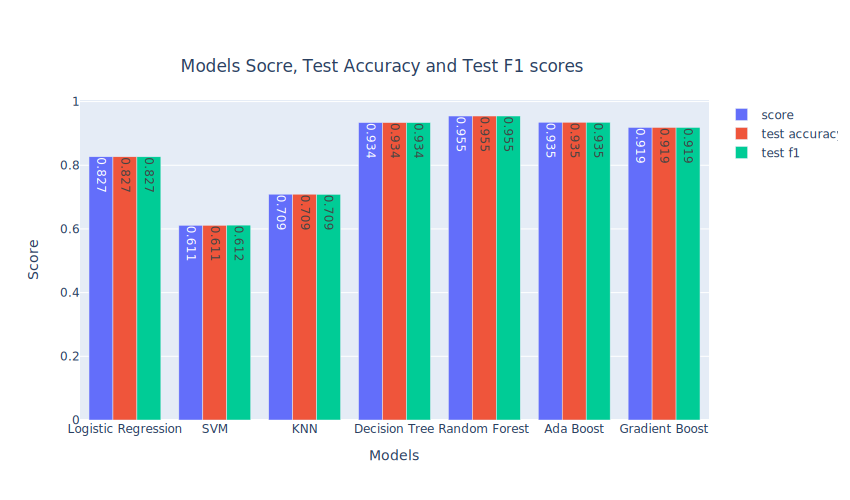

In [60]:
import plotly.graph_objects as go

# Create a DataFrame to display results
df_results = pd.DataFrame(results).transpose()
df_results.index.name = 'Model'
print(df_results)

# Display the display results with Plotly
fig = go.Figure(data=[
    go.Bar(name='score', x=df_results.index, y=df_results.score, text=df_results.score),
    go.Bar(name='test accuracy', x=df_results.index, y=df_results.test_accuracy, text=df_results.test_accuracy),
    go.Bar(name='test f1', x=df_results.index, y=df_results.test_f1, text=df_results.test_f1)])
fig.update_layout(title="Models Socre, Test Accuracy and Test F1 scores", title_x=0.45, title_y=0.88,
                  yaxis_title='Score', xaxis_title='Models', height=500, width=850)
fig.update_traces(texttemplate='%{y:.3f}')
fig.show()